In [1]:
symmetic vs relation/no relation
sequential probability ratio test

SyntaxError: invalid syntax (<ipython-input-1-98ae844e7c9c>, line 1)

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import itertools as it
sns.set_style('white')
sns.set_context('talk', font_scale=1.2)
sns.set_palette(sns.color_palette('tab10'))


from matplotlib import rcParams
rcParams['figure.figsize'] = (8, 6)

from scipy.stats import binom, beta
from scipy.special import beta as B

# Biased memory of a possibly biased coin

You have to predict whether a coin is fair or biased based on observing a finite
number of flip sequences of the coin. However, you can only remember a subset of
the sequences. How should you decide which sequences to remember to maximize your
probability of correctly predicting if the coin is biased or not? Does this strategy
lead you to be biased towards giving one answer vs. another?

We'll represent the data $D$ as a sequences of head-counts $x$, where
each flip sequence contains $N$ flips.
To make our decision, we will compare the likelihood ratio of the two alternative
hypotheses. 

$$
\newcommand{\binom}{\text{Binomial}}
p(D \mid H_0) = \prod_{x \in D} \binom(x; n, 0.5) \\
p(D \mid H_1) = \int_0^1 \prod_{x \in D} p(\theta) \binom(x; n, \theta) \ d\theta
$$

We integrate out the biased probability $\theta$ because $H_1$ just states that the coin
is biased somehow, not that it has some specific bias. We don't know a-priori how the coin is
biased, so we have a uniform distribution for $p(\theta)$, i.e. $p(\theta) = 1$.

If $p(D \mid H_1) > p(D \mid H_0)$, we'll say the coin is biased.

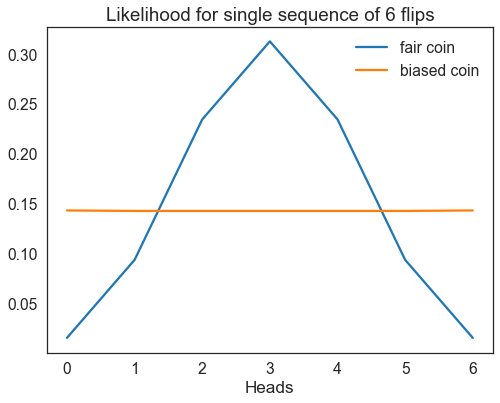

In [3]:
def h0_log_likelihood(D, N=6):
    """Log likelihood of multiple sequences of N flips of a **fair** coin."""
    return binom(N, 0.5).logpmf(D).sum()

def h1_log_likelihood(D, N=6):
    """Log likelihood of multiple sequences of N flips of a **biased** coin."""
    p = np.linspace(0, 1, 1000)  # numerically integrate out the biased p
    likelihood_per_p = binom(N, p).logpmf(np.array(D).reshape(-1, 1)).sum(0)
    return np.log(np.exp(likelihood_per_p).mean())

xs = np.arange(7)
h0 = np.array([h0_log_likelihood([x]) for x in xs])
h1 = np.array([h1_log_likelihood([x]) for x in xs])
plt.plot(xs, np.exp(h0), label='fair coin')
plt.plot(xs, np.exp(h1), label='biased coin')
plt.xlabel('Heads')
plt.title('Likelihood for single sequence of 6 flips')
plt.legend()

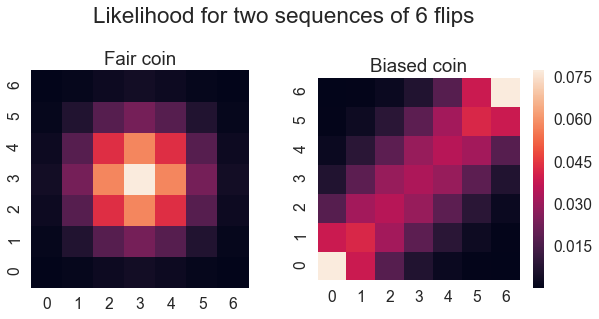

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
plt.sca(axes[0])
h0 = np.array([[np.exp(h0_log_likelihood([i, j])) for i in xs] for j in xs])
sns.heatmap(h0, cbar=False, square=True).invert_yaxis()
plt.title('Fair coin')

plt.sca(axes[1])
h1 = np.array([[np.exp(h1_log_likelihood([i, j])) for i in xs] for j in xs])
sns.heatmap(h1, square=True).invert_yaxis()
plt.title('Biased coin')
plt.suptitle('Likelihood for two sequences of 6 flips', y=1.1)

## The distribution of LLR is skewed

Below we see that a few possible data points provide very strong evidence for $H_1$
while many possible data points provide weak evidence for $H_0$.


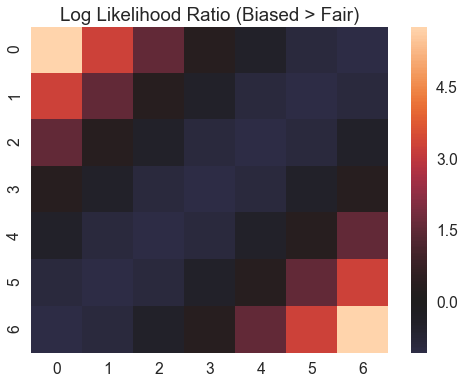

In [7]:
sns.heatmap(np.log(h1) - np.log(h0), center=0)
plt.title('Log Likelihood Ratio (Biased > Fair)')

## LLR depends only on the total number of heads and tails

The diagonal pattern above additionally shows that the LLR depends only on
the total number of heads and tails seen in the complete data set. That is,
[HHHT, THHH] provides the same evidence as [HHTT, TTHH]. This allows us
to write down an efficient LLR function.

In [8]:
from scipy.special import gamma

def log_likelihood_ratio(heads, tails, a=1, b=1):
    """Computes llr based on the total number of heads and tails seen so far.
    
    H0: p = 0.5
    H1: p ~ Beta(a, b)
    """
    # The binomial coefficient in numerator and denominator cancels.
    h1 = np.log((gamma(heads + a) * gamma(tails + b) * gamma(a + b)) /
                (gamma(heads + a + tails + b) * gamma(a) * gamma(b)))
    h0 = np.log(0.5) * (heads + tails)
    return h1 - h0

## How should you choose what sequences to remember?

Our goal is to maximize our chance of identifying the correct hypothesis while
remembering only a subset of the data we see. To simplify things, we'll assume
that our memory preference is independent of the data we've already seen. (Would the 
optimal strategy follow this assumption?)

Specifically, we'll consider two possible preference functions. One is completely random.
The second is somewhat random, but has some preference for sequences that provide strong
evidence for one hypothesis over the other, i.e. those whose log likelihood ratios have
high absolute value.

In [17]:
def dataset(n, p, size):
    heads = binom(n, p).rvs(size)
    tails = n - heads
    return heads, tails

def select(llr, n, weight=0):
    """Returns a length-`n` index, biased towards positions where abs(llr) is high."""
    idx = np.argsort(weight * np.abs(llr) + (1 - weight) * np.random.rand())
    return idx[-n:]

def experiment(size=20, n=6, memory=0.5, weight=0, strong_bias=False):
    """Choose between H0 and H1 from limited memory of several flip sequences.
    
    size: the number of sequences
    n: the number of flips in one sequence
    memory: the percentage of sequences remembered
    weight: the stregnth of preference for remembering sequences with high abs(LLR)
    strong_bias: if True, the coin is known to be either fair or strongly biased (p near 0 or 1)
    """
    bias = np.random.rand() > 0.5
    a = b = 0.2 if strong_bias else 1
    p = beta(a, b).rvs() if bias else 0.5
    heads, tails = dataset(n, p, size)
    llr = log_likelihood_ratio(heads, tails, a, b)
    idx = select(llr, int(memory*size), weight)
    partial = llr[idx].mean()
    choice = partial > 0
    return {
        'size': size, 'memory': memory, 'weight': weight, 'strong_bias': strong_bias,
        'bias': bias, 'p': p,
        'full_llr': llr.mean(),  'partial_llr': partial,
        'prob_h1': np.exp(llr) / (1 + np.exp(llr)), 
        'choice': choice, 'correct': choice == bias,
    }

def dict_product(d):
    """All possible combinations of values in lists in `d`"""
    for k, v in d.items():
        if not isinstance(v, list):
            d[k] = [v]
    for v in list(it.product(*d.values())):
        yield dict(zip(d.keys(), v))

params = dict_product({
    'size': [10, 20, 40],
    'memory': [0.2, 0.8],
    'weight': [0, 1]
})

n_trial = 5000
df = pd.DataFrame(experiment(**prm) for prm in params for _ in range(n_trial))
df

,bias,choice,correct,full_llr,memory,p,partial_llr,prob_h1,size,strong_bias,weight
0,False,True,False,-0.098551,0.2,0.500000,1.317093,"[0.378698224852, 0.378698224852, 0.37869822485...",10,False,0
1,False,False,True,-0.460985,0.2,0.500000,-0.495077,"[0.378698224852, 0.378698224852, 0.37869822485...",10,False,0
2,True,False,False,-0.186097,0.2,0.221952,-0.036932,"[0.378698224852, 0.603773584906, 0.60377358490...",10,False,0
3,False,False,True,-0.460985,0.2,0.500000,-0.495077,"[0.378698224852, 0.313725490196, 0.37869822485...",10,False,0
4,False,True,False,-0.339345,0.2,0.500000,0.715107,"[0.378698224852, 0.378698224852, 0.37869822485...",10,False,0
5,False,False,True,-0.094468,0.2,0.500000,-0.036932,"[0.603773584906, 0.603773584906, 0.60377358490...",10,False,0
6,True,False,False,-0.277726,0.2,0.507234,-0.495077,"[0.313725490196, 0.603773584906, 0.37869822485...",10,False,0
7,True,True,True,1.137917,0.2,0.825826,0.421213,"[0.901408450704, 0.901408450704, 0.60377358490...",10,False,0
8,False,False,True,-0.518521,0.2,0.500000,-0.495077,"[0.313725490196, 0.603773584906, 0.37869822485...",10,False,0
9,True,False,False,-0.426892,0.2,0.451741,-0.638918,"[0.313725490196, 0.378698224852, 0.37869822485...",10,False,0


## Results

### Accuracy
LLR-preferential sampling increases the probability of identifying the
correct hypothesis when memory is severely limited. It has the reverse effect
when memory is only weakly limited.

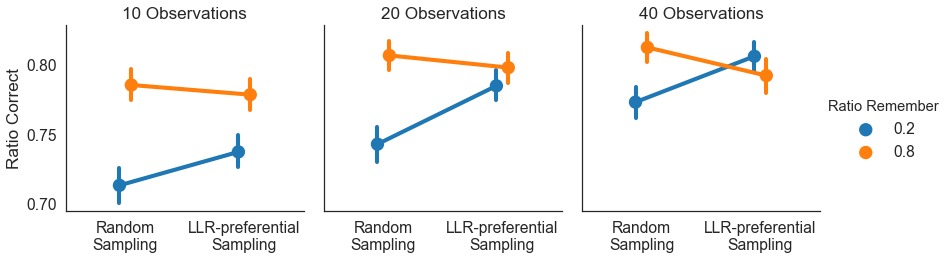

In [14]:
g = sns.factorplot('weight', 'correct', hue='memory', col='size', 
                   data=df, dodge=.1, legend=False)

(g.set_xticklabels(['Random\nSampling', 'LLR-preferential\nSampling'])
  .set_axis_labels('', 'Ratio Correct')
  .set_titles('{col_name} Observations')
  .add_legend(title='Ratio Remember')
)

### Bias
In general, we appear to be biased towards predicting that the coin is fair. This
may be because the coin could can a very weak bias which is difficult to detect.

LLR-preferential sampling reduces this bias when memory is strongly limited. Again, it
has the reverse effect for weakly limited memory. The de-biasing effect weakens as
the size of the dataset increases.

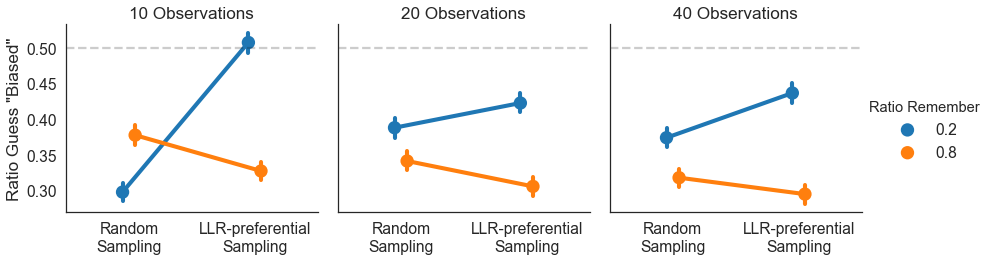

In [15]:
g = sns.factorplot('weight', 'choice', hue='memory', col='size', 
                   data=df, dodge=.1, legend=False)

(g.set_xticklabels(['Random\nSampling', 'LLR-preferential\nSampling'])
  .map(lambda **_: plt.axhline(0.5, ls='--', c='k', alpha=0.2))
  .set_axis_labels('', 'Ratio Guess "Biased"')
  .set_titles('{col_name} Observations')
  .add_legend(title='Ratio Remember')
)